<a href="https://colab.research.google.com/github/IvoandricGBC/Project-MLI-GBC/blob/main/distance_estimation_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# ─── MÓDULO B: CARGA, CONFIGURACIÓN Y SPLIT ───


# 1. Semilla global para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 2. Definición de rutas
env_name = 'distance_estimation'
base_dir  = f"/content/drive/MyDrive/Colab Notebooks/{env_name}"
csv_path  = os.path.join(base_dir, 'labels.csv')
img_dir   = os.path.join(base_dir, 'images')

# 3. Carga de datos de metadatos
df = pd.read_csv(csv_path)
# Forzamos que ID sea string para todo el pipeline
df['ID'] = df['ID'].astype(str)

assert 'class' in df.columns, "Falta la columna 'class' en labels.csv"

# 4. Split estratificado en train/val
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['class']  # conserva proporción de clases
)

# 5. Feedback por consola
print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}")
print("Distribución de clases en train:\n", train_df['class'].value_counts(normalize=True))
print("Distribución de clases en val:\n",   val_df  ['class'].value_counts(normalize=True))

# 6. Opcional: inspección rápida de algunas rutas
print(f"Ejemplo de imagen disponible en: {os.path.join(img_dir, train_df.iloc[0]['ID'] + '.png')}")


Train shape: (400, 6), Val shape: (100, 6)
Distribución de clases en train:
 class
1    0.5275
0    0.4725
Name: proportion, dtype: float64
Distribución de clases en val:
 class
1    0.53
0    0.47
Name: proportion, dtype: float64
Ejemplo de imagen disponible en: /content/drive/MyDrive/Colab Notebooks/distance_estimation/images/164.png


In [3]:
# ─── MÓDULO C: DATASET Y TRANSFORMACIONES ───

# ─── MÓDULO C: DATASET Y TRANSFORMACIONES ───

import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 1. Columnas de metadata
metadata_cols = ['Width', 'location']

# 2. Escalado de metadatos (solo sobre train ¡IMPORTANTE!)
metadata_scaler = StandardScaler()

# Ajuste y transformación en train
scaled_train = metadata_scaler.fit_transform(train_df[metadata_cols].astype(float))
train_df[metadata_cols] = pd.DataFrame(scaled_train, columns=metadata_cols, index=train_df.index)

# Transformación en val
scaled_val = metadata_scaler.transform(val_df[metadata_cols].astype(float))
val_df[metadata_cols] = pd.DataFrame(scaled_val, columns=metadata_cols, index=val_df.index)

# 3. Normalización del label (min-max) basada en train_df
min_l, max_l = train_df['label'].min(), train_df['label'].max()
train_df['label_norm'] = (train_df['label'] - min_l) / (max_l - min_l)
val_df['label_norm']   = (val_df['label']   - min_l) / (max_l - min_l)

# 4. Transformaciones de imagen
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 5. Dataset personalizado
class DistanceDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['ID']}.png")
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        meta_vals = row[metadata_cols].values.astype(np.float32)
        meta = torch.from_numpy(meta_vals)
        label = torch.tensor(row['label_norm'], dtype=torch.float32)
        return img, meta, label

# 6. DataLoaders
batch_size = 32
train_ds = DistanceDataset(train_df, img_dir, transform=train_transforms)
val_ds   = DistanceDataset(val_df,   img_dir, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True)

print(f"[+] DataLoaders OK — {len(train_ds)} imgs en train, {len(val_ds)} en val")


[+] DataLoaders OK — 400 imgs en train, 100 en val


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# ─── MÓDULO D: DATALOADERS AVANZADOS ───

import torch
from torch.utils.data import DataLoader

# Parámetros comunes
batch_size = 32      # o ajústalo según tu memoria disponible
num_workers = 4      # idealmente = número de CPUs disponibles
prefetch_factor = 2  # cuántos batches prefetch por worker
drop_last = True     # para mantener consistencia de tamaño de batch

# Generador para reproducibilidad en el shuffle
g = torch.Generator()
g.manual_seed(SEED)

# 1. Train loader con shuffling reproducible
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=prefetch_factor,
    drop_last=drop_last,
    generator=g
)

# 2. Val loader sin shuffle
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=prefetch_factor,
    drop_last=False
)

# 3. (Opcional) Sampler ponderado si hubiera desbalance
# from torch.utils.data import WeightedRandomSampler
# class_counts = train_df['class'].value_counts().to_dict()
# weights = [1.0 / class_counts[c] for c in train_df['class']]
# sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
# train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, ...)

print(f"[+] Train loader: {len(train_loader)} batches, Val loader: {len(val_loader)} batches")


[+] Train loader: 12 batches, Val loader: 4 batches


In [5]:
# ─── MÓDULO E: ARQUITECTURA DEL MODELO ───

import torch
import torch.nn as nn
from torchvision import models

class DistanceModel(nn.Module):
    def __init__(self, num_meta_feat, head_sizes=[256, 128], backbone_name='resnet50', pretrained=True):
        super().__init__()
        # 1. Backbone CNN
        if backbone_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
        elif backbone_name == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
        else:
            raise ValueError(f"Backbone {backbone_name} no soportado")

        # 2. Congelar todas las capas excepto layer4 (freezing progresivo)
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False
            if 'layer4' in name:
                param.requires_grad = True

        # 3. Sustituir la cabeza final de la CNN
        cnn_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()   # deja pasar los features puros

        # 4. MLP para metadata
        self.meta_net = nn.Sequential(
            nn.Linear(num_meta_feat, head_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(head_sizes[0], head_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # 5. Cabeza combinada (imagen + metadata)
        self.head = nn.Sequential(
            nn.Linear(cnn_feats + head_sizes[1], 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # salida regresión
        )

    def forward(self, img, meta):
        # Extraer features de la imagen
        x_img = self.backbone(img)           # [batch, cnn_feats]
        # Procesar metadata
        x_meta = self.meta_net(meta)         # [batch, head_sizes[1]]
        # Concatenar
        x = torch.cat([x_img, x_meta], dim=1)
        # Cabeza final
        return self.head(x)

# ─ Instanciación ─
num_meta = len(metadata_cols)  # p.ej. ['Width','location'] → 2
model = DistanceModel(num_meta_feat=num_meta, backbone_name='resnet50').to(device)

# ─── MÓDULO E: ARQUITECTURA DEL MODELO ───
# (todo lo que ya tienes, incluida la clase DistanceModel y la instanciación)
model = DistanceModel(num_meta_feat=num_meta, backbone_name='resnet50').to(device)

# ─── Configuración del optimizador con LRs diferenciados ───
import torch.optim as optim

optimizer = optim.Adam([
    # 1) Ajuste fino suave de layer4 (backbone)
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
    # 2) Aprendizaje más rápido de la MLP de metadata
    {'params': model.meta_net.parameters(),           'lr': 1e-3},
    # 3) Cabeza combinada imagen+metadata
    {'params': model.head.parameters(),               'lr': 1e-3},
])



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# ─── MÓDULO F: BUCLE DE ENTRENAMIENTO CON MIXED PRECISION (torch.amp) Y EARLY STOPPING ───

import numpy as np
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Configuración básica
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_str  = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn      = nn.MSELoss()
amp_scaler = GradScaler(device_str)
num_epochs   = 50
patience     = 5
best_val_loss = float('inf')
stale_epochs  = 0

# 2. Loop de epochs
for epoch in range(1, num_epochs + 1):
    # ––– Entrenamiento –––
    model.train()
    train_losses = []
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_str):
            preds = model(imgs, metas).squeeze(1)
            loss  = loss_fn(preds, labels)
        amp_scaler.scale(loss).backward()
        amp_scaler.step(optimizer)
        amp_scaler.update()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # ––– Validación –––
    model.eval()
    val_losses  = []
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            with autocast(device_str):
                preds = model(imgs, metas).squeeze(1)
                loss  = loss_fn(preds, labels)
            val_losses.append(loss.item())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    val_loss = np.mean(val_losses)
    y_pred   = torch.cat(all_preds).numpy()
    y_true   = torch.cat(all_labels).numpy()
    val_mae  = mean_absolute_error(y_true, y_pred)
    val_r2   = r2_score(y_true, y_pred)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss:   {val_loss:.4f} | "
        f"Val MAE:    {val_mae:.4f} | "
        f"Val R²:     {val_r2:.4f}"
    )

    # ––– Early Stopping y checkpoint –––
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stale_epochs  = 0
        torch.save({
            'epoch':        epoch,
            'model_state':  model.state_dict(),
            'opt_state':    optimizer.state_dict(),
            'scaler_state': amp_scaler.state_dict()
        }, 'best_checkpoint.pt')
        print("  → Mejor modelo guardado")
    else:
        stale_epochs += 1
        if stale_epochs >= patience:
            print(f"Stopping early! No mejora en {patience} epochs.")
            break


Epoch 01 | Train Loss: 0.3705 | Val Loss:   0.0407 | Val MAE:    0.1631 | Val R²:     0.3242
  → Mejor modelo guardado
Epoch 02 | Train Loss: 0.0747 | Val Loss:   0.0951 | Val MAE:    0.2661 | Val R²:     -0.6762
Epoch 03 | Train Loss: 0.0621 | Val Loss:   0.0247 | Val MAE:    0.1415 | Val R²:     0.5064
  → Mejor modelo guardado
Epoch 04 | Train Loss: 0.0394 | Val Loss:   0.0180 | Val MAE:    0.1158 | Val R²:     0.6347
  → Mejor modelo guardado
Epoch 05 | Train Loss: 0.0369 | Val Loss:   0.0257 | Val MAE:    0.1392 | Val R²:     0.4899
Epoch 06 | Train Loss: 0.0310 | Val Loss:   0.0129 | Val MAE:    0.0974 | Val R²:     0.7414
  → Mejor modelo guardado
Epoch 07 | Train Loss: 0.0298 | Val Loss:   0.0143 | Val MAE:    0.0875 | Val R²:     0.7878
Epoch 08 | Train Loss: 0.0295 | Val Loss:   0.0096 | Val MAE:    0.0778 | Val R²:     0.8350
  → Mejor modelo guardado
Epoch 09 | Train Loss: 0.0278 | Val Loss:   0.0100 | Val MAE:    0.0825 | Val R²:     0.8217
Epoch 10 | Train Loss: 0.0258 | 

In [7]:
# ─── MÓDULO G.1 (versión con validación) ───

import torch.optim as optim
from torch.amp import autocast

# 1. Restaurar checkpoint
ckpt = torch.load('best_checkpoint.pt', map_location=device)
model.load_state_dict(ckpt['model_state'])
optimizer.load_state_dict(ckpt['opt_state'])
amp_scaler.load_state_dict(ckpt['scaler_state'])

# 2. Descongelar layer3 + layer4
for name, param in model.backbone.named_parameters():
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad = True

# 3. Reconfigurar optimizador
optimizer = optim.Adam([
    {'params': model.backbone.layer3.parameters(), 'lr': 5e-5},
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
    {'params': model.meta_net.parameters(),           'lr': 1e-3},
    {'params': model.head.parameters(),               'lr': 1e-3},
])

# 4. Fine-tuning con validación
fine_epochs = 10
for epoch in range(1, fine_epochs + 1):
    # --- Entrenamiento ---
    model.train()
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_str):
            loss = loss_fn(model(imgs, metas).squeeze(1), labels)
        amp_scaler.scale(loss).backward()
        amp_scaler.step(optimizer)
        amp_scaler.update()
    # --- Validación ---
    model.eval()
    val_losses, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            with autocast(device_str):
                preds = model(imgs, metas).squeeze(1)
                val_losses.append(loss_fn(preds, labels).item())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    val_loss = sum(val_losses) / len(val_losses)
    y_pred   = torch.cat(all_preds).numpy()
    y_true   = torch.cat(all_labels).numpy()
    val_mae  = mean_absolute_error(y_true, y_pred)
    val_r2   = r2_score(y_true, y_pred)

    print(
        f"[Fine-Tuning] Epoch {epoch:02d} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val MAE:  {val_mae:.4f} | "
        f"Val R²:   {val_r2:.4f}"
    )

print("→ Fine-tuning de layer3+4 completado")



[Fine-Tuning] Epoch 01 | Val Loss: 0.0216 | Val MAE:  0.1277 | Val R²:   0.5863
[Fine-Tuning] Epoch 02 | Val Loss: 0.0099 | Val MAE:  0.0841 | Val R²:   0.8126
[Fine-Tuning] Epoch 03 | Val Loss: 0.0173 | Val MAE:  0.1073 | Val R²:   0.7165
[Fine-Tuning] Epoch 04 | Val Loss: 0.0116 | Val MAE:  0.0806 | Val R²:   0.8134
[Fine-Tuning] Epoch 05 | Val Loss: 0.0114 | Val MAE:  0.0850 | Val R²:   0.8109
[Fine-Tuning] Epoch 06 | Val Loss: 0.0041 | Val MAE:  0.0559 | Val R²:   0.9198
[Fine-Tuning] Epoch 07 | Val Loss: 0.0044 | Val MAE:  0.0568 | Val R²:   0.9065
[Fine-Tuning] Epoch 08 | Val Loss: 0.0068 | Val MAE:  0.0707 | Val R²:   0.8597
[Fine-Tuning] Epoch 09 | Val Loss: 0.0025 | Val MAE:  0.0422 | Val R²:   0.9494
[Fine-Tuning] Epoch 10 | Val Loss: 0.0187 | Val MAE:  0.1196 | Val R²:   0.6908
→ Fine-tuning de layer3+4 completado


In [8]:
#!pip install optuna


In [9]:
# ─── MÓDULO G.2: BÚSQUEDA DE HYPERPARÁMETROS CON OPTUNA ───

import optuna
import torch.optim as optim
from torch.amp import autocast, GradScaler
from sklearn.metrics import mean_absolute_error

# 1. Función objetivo
def objective(trial):
    # Hiparams a explorar
    lr_back3 = trial.suggest_loguniform('lr_back3', 1e-5, 1e-4)
    lr_back4 = trial.suggest_loguniform('lr_back4', 1e-5, 1e-4)
    lr_meta  = trial.suggest_loguniform('lr_meta',  1e-4, 1e-2)
    head1    = trial.suggest_categorical('head1',    [128, 256, 512])
    head2    = trial.suggest_categorical('head2',    [64, 128, 256])
    drop_p   = trial.suggest_uniform('dropout',      0.1, 0.5)

    # Reconstruir modelo
    model = DistanceModel(
        num_meta_feat=num_meta,
        head_sizes=[head1, head2],
        backbone_name='resnet50'
    ).to(device)
    # Ajustar dropout dinámico
    for m in model.meta_net:
        if isinstance(m, nn.Dropout):
            m.p = drop_p
    for m in model.head:
        if isinstance(m, nn.Dropout):
            m.p = drop_p

    # Congelar todo menos layer3+4 inicialmente
    for name, param in model.backbone.named_parameters():
        param.requires_grad = False
        if 'layer3' in name or 'layer4' in name:
            param.requires_grad = True

    # Optimizador con tasas diferenciadas
    optimizer = optim.Adam([
        {'params': model.backbone.layer3.parameters(), 'lr': lr_back3},
        {'params': model.backbone.layer4.parameters(), 'lr': lr_back4},
        {'params': model.meta_net.parameters(),           'lr': lr_meta},
        {'params': model.head.parameters(),               'lr': lr_meta},
    ])
    amp_scaler = GradScaler(device_str)

    # Entrenar 3 epochs rápidos
    model.train()
    for _ in range(3):
        for imgs, metas, labels in train_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_str):
                preds = model(imgs, metas).squeeze(1)
                loss  = nn.MSELoss()(preds, labels)
            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimizer)
            amp_scaler.update()

    # Validación MAE
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            preds = model(imgs, metas).squeeze(1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    val_mae = mean_absolute_error(y_true, y_pred)
    return val_mae

# 2. Lanzar estudio
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("▶️ Mejores parámetros:", study.best_params)
print("▶️ Mejor MAE:",      study.best_value)


[I 2025-05-26 00:55:54,687] A new study created in memory with name: no-name-c45d4fa4-5040-41d7-8d5a-47cb5af34970
<ipython-input-9-33fb160172b8>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_back3 = trial.suggest_loguniform('lr_back3', 1e-5, 1e-4)
<ipython-input-9-33fb160172b8>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_back4 = trial.suggest_loguniform('lr_back4', 1e-5, 1e-4)
<ipython-input-9-33fb160172b8>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_meta  = trial.suggest_loguniform('lr_

▶️ Mejores parámetros: {'lr_back3': 6.249420744245936e-05, 'lr_back4': 9.320372972406882e-05, 'lr_meta': 0.00032378993016874487, 'head1': 512, 'head2': 256, 'dropout': 0.29264991688727415}
▶️ Mejor MAE: 0.06555480509996414


In [10]:
# ─── MÓDULO H: ENTRENAMIENTO FINAL CON BEST_PARAMS ───

import torch.optim as optim
from torch.amp import autocast, GradScaler

# 1. Extraer mejores hiperparámetros
bp = study.best_params
lr_back3 = bp['lr_back3']
lr_back4 = bp['lr_back4']
lr_meta  = bp['lr_meta']
head1    = bp['head1']
head2    = bp['head2']
drop_p   = bp['dropout']

# 2. Reconstruir modelo con best head sizes y dropout
model = DistanceModel(
    num_meta_feat=num_meta,
    head_sizes=[head1, head2],
    backbone_name='resnet50'
).to(device)

# Ajustar dropout dinámico
for m in model.meta_net:
    if isinstance(m, nn.Dropout):
        m.p = drop_p
for m in model.head:
    if isinstance(m, nn.Dropout):
        m.p = drop_p

# 3. Congelar todo menos layer3+4
for name, param in model.backbone.named_parameters():
    param.requires_grad = False
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad = True

# 4. Optimizer con tasas diferenciadas
optimizer = optim.Adam([
    {'params': model.backbone.layer3.parameters(), 'lr': lr_back3},
    {'params': model.backbone.layer4.parameters(), 'lr': lr_back4},
    {'params': model.meta_net.parameters(),           'lr': lr_meta},
    {'params': model.head.parameters(),               'lr': lr_meta},
])

# 5. Escaler y loss
amp_scaler     = GradScaler(device_str)
loss_fn    = nn.MSELoss()
num_epochs = 30
patience   = 7
best_val   = float('inf')
stale      = 0

# 6. Loop completo
for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    train_losses = []
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_str):
            preds = model(imgs, metas).squeeze(1)
            loss  = loss_fn(preds, labels)
        amp_scaler.scale(loss).backward()
        amp_scaler.step(optimizer)
        amp_scaler.update()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    val_losses, preds, trues = [], [], []
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            with autocast(device_str):
                out = model(imgs, metas).squeeze(1)
                val_losses.append(loss_fn(out, labels).item())
            preds.append(out.cpu())
            trues.append(labels.cpu())
    # Métricas
    val_loss = sum(val_losses) / len(val_losses)
    y_pred   = torch.cat(preds).numpy()
    y_true   = torch.cat(trues).numpy()
    val_mae  = mean_absolute_error(y_true, y_pred)
    val_r2   = r2_score(y_true, y_pred)
    print(f"Epoch {epoch:02d} | Train Loss: {np.mean(train_losses):.4f} | Val MAE: {val_mae:.4f} | Val R²: {val_r2:.4f}")

    # Early stopping simple
    if val_loss < best_val:
        best_val = val_loss
        stale    = 0
        torch.save(model.state_dict(), 'final_model.pt')
    else:
        stale += 1
        if stale >= patience:
            print(f"No mejora en {patience} epochs. Deteniendo.")
            break

print("Entrenamiento finalizado. Modelo guardado en final_model.pt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | Train Loss: 0.0967 | Val MAE: 0.1376 | Val R²: 0.5207
Epoch 02 | Train Loss: 0.0513 | Val MAE: 0.1169 | Val R²: 0.6748
Epoch 03 | Train Loss: 0.0430 | Val MAE: 0.0970 | Val R²: 0.7324
Epoch 04 | Train Loss: 0.0358 | Val MAE: 0.0855 | Val R²: 0.7962
Epoch 05 | Train Loss: 0.0307 | Val MAE: 0.0726 | Val R²: 0.8638
Epoch 06 | Train Loss: 0.0255 | Val MAE: 0.0546 | Val R²: 0.9137
Epoch 07 | Train Loss: 0.0288 | Val MAE: 0.1124 | Val R²: 0.6770
Epoch 08 | Train Loss: 0.0287 | Val MAE: 0.0419 | Val R²: 0.9492
Epoch 09 | Train Loss: 0.0256 | Val MAE: 0.0551 | Val R²: 0.9167
Epoch 10 | Train Loss: 0.0223 | Val MAE: 0.0741 | Val R²: 0.8507
Epoch 11 | Train Loss: 0.0252 | Val MAE: 0.0655 | Val R²: 0.8934
Epoch 12 | Train Loss: 0.0210 | Val MAE: 0.0685 | Val R²: 0.8837
Epoch 13 | Train Loss: 0.0221 | Val MAE: 0.0650 | Val R²: 0.8896
Epoch 14 | Train Loss: 0.0245 | Val MAE: 0.0630 | Val R²: 0.8947
Epoch 15 | Train Loss: 0.0214 | Val MAE: 0.0789 | Val R²: 0.8461
No mejora en 7 epochs. De

In [12]:
# ─── MÓDULO I: EVALUACIÓN EN TEST Y PIPELINE DE INFERENCIA ───

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Carga tu CSV de test (mismo preprocessing que en train/val)
test_df = pd.read_csv(csv_path)  # o la ruta de tu test.csv
test_df['ID']       = test_df['ID'].astype(str)
# Escalado de metadata
test_df[metadata_cols] = metadata_scaler.transform(test_df[metadata_cols].astype(float))
# Normalización de label
test_df['label_norm']   = (test_df['label'] - min_l) / (max_l - min_l)

# 2. DataLoader de test
test_ds = DistanceDataset(test_df, img_dir, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)

# 3. Carga del modelo final
model.load_state_dict(torch.load('final_model.pt', map_location=device))
model.to(device).eval()

# 4. Inferencia y métricas
all_preds, all_trues = [], []
with torch.no_grad():
    for imgs, metas, labels in test_loader:
        imgs, metas = imgs.to(device), metas.to(device)
        preds = model(imgs, metas).squeeze(1).cpu().numpy()
        all_preds.extend(preds)
        all_trues.extend(labels.numpy())

# 5. Desnormalizar predicciones
all_trues = np.array(all_trues) * (max_l - min_l) + min_l
all_preds = np.array(all_preds) * (max_l - min_l) + min_l

mae = mean_absolute_error(all_trues, all_preds)
r2  = r2_score(all_trues, all_preds)
print(f"Test MAE: {mae:.4f} | Test R²: {r2:.4f}")

# 6. Tabla comparativa (opcional)
results = pd.DataFrame({
    'ID':    test_df['ID'],
    'true':  all_trues,
    'pred':  all_preds
})
print(results.head(20))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test MAE: 2.8892 | Test R²: 0.9411
    ID       true       pred
0    0  48.000000  51.596443
1    1  49.000000  48.048901
2    2  54.000000  50.350582
3    3  13.000000  18.857775
4    4  47.000000  47.053295
5    5  43.000000  45.595009
6    6  44.000000  45.607521
7    7  46.000000  39.354137
8    8  26.000000  25.721512
9    9  52.999996  54.452217
10  10  35.000000  33.034973
11  11  35.000000  34.641846
12  12  16.000000  20.202078
13  13  66.000000  65.696548
14  14  56.000000  52.579315
15  15  59.000000  54.473911
16  16  38.000000  37.937286
17  17  20.000000  21.511446
18  18  54.000000  49.600704
19  19  35.000000  34.770599


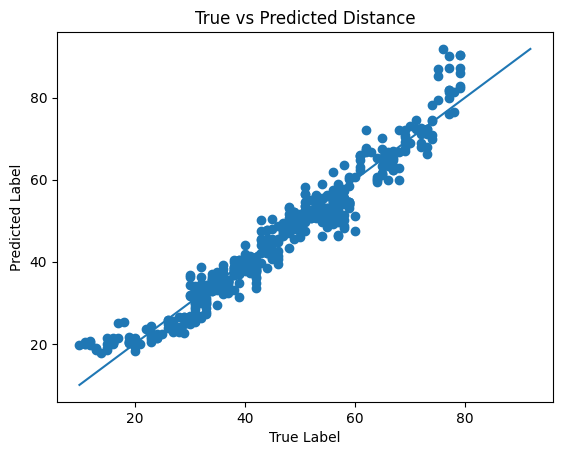

In [13]:
import matplotlib.pyplot as plt

# Asumiendo que 'results' existe en el entorno
# Si no, puedes reconstruirlo usando test_df, all_trues, all_preds
# Aquí utilizamos directamente 'results'
true_vals = results['true'].values
pred_vals = results['pred'].values

plt.figure()
plt.scatter(true_vals, pred_vals)
min_val = min(true_vals.min(), pred_vals.min())
max_val = max(true_vals.max(), pred_vals.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('True vs Predicted Distance')
plt.show()


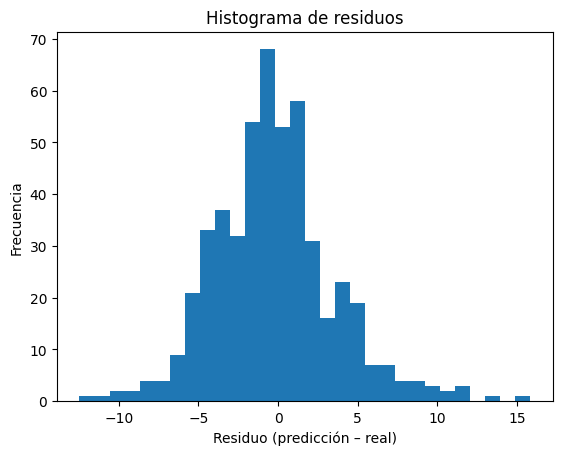

<ipython-input-16-c6a57731b0ef>:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(bin_groups, labels=results['true_bin'].cat.categories)


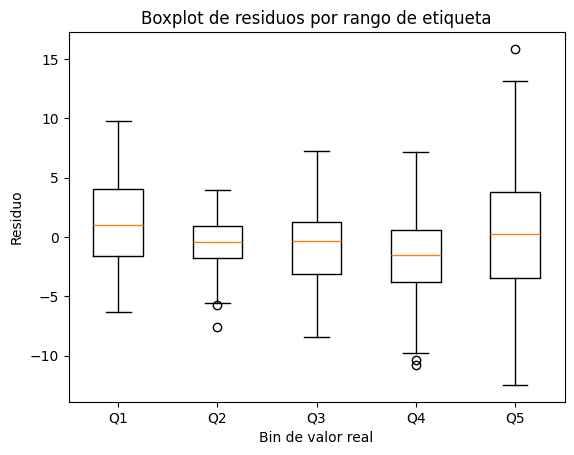

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame `results` con columnas 'true' y 'pred'
results['residual'] = results['pred'] - results['true']

# 1) Histograma de residuos
plt.figure()
plt.hist(results['residual'], bins=30)
plt.xlabel('Residuo (predicción – real)')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

# 2) Boxplot de residuos por bins de la etiqueta real
# Definimos 5 bins iguales sobre la variable true
results['true_bin'] = pd.qcut(results['true'], q=5, labels=[f'Q{i+1}' for i in range(5)])
bin_groups = [results[results['true_bin']==b]['residual'] for b in results['true_bin'].cat.categories]

plt.figure()
plt.boxplot(bin_groups, labels=results['true_bin'].cat.categories)
plt.xlabel('Bin de valor real')
plt.ylabel('Residuo')
plt.title('Boxplot de residuos por rango de etiqueta')
plt.show()


In [14]:
scripted = torch.jit.script(model)
scripted.save('model_scripted.pt')
